In [222]:
import numpy as np
import soundfile
import argparse
import librosa.core as lc
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt

In [331]:
#written by S.I. Mimilakis, minor modifications by me
#https://github.com/TUIlmenauAMS/ASP/tree/64782c3ff9564b06677c2a2112b2b2bdb48dc2a1

class PsychoacousticModel:
    """ Class that performs a very basic psychoacoustic model.
        Bark scaling is based on Perceptual-Coding-In-Python, [Online] :
        https://github.com/stephencwelch/Perceptual-Coding-In-Python
    """
    def __init__(self, N = 4096, fs = 44100, nfilts=24, type = 'rasta', width = 1.0, minfreq=0, maxfreq=22050):

        self.nfft = N
        self.fs = fs
        self.nfilts = nfilts
        self.width = width
        self.min_freq = minfreq
        self.max_freq = maxfreq
        self.max_freq = fs/2
        self.nfreqs = N/2
        self._LTeq = np.zeros(nfilts, dtype = np.float32)

        # Type of transformation
        self.type = type

        # Computing the matrix for forward Bark transformation
        self.W = self.mX2Bark(type)

        # Computing the inverse matrix for backward Bark transformation
        self.W_inv = self.bark2mX()

        # Non-linear superposition parameters
        self._alpha = 0.9                                       # Exponent alpha
        self._maxb = 1./self.nfilts                             # Bark-band normalization
        self._fa = 1./(10 ** (14.5/20.) * 10 ** (12./20.))      # Tone masking approximation
        self._fb = 1./(10**(7.5/20.))                           # Upper slope of spreading function
        self._fbb = 1./(10**(26./20.))                          # Lower slope of spreading function
        self._fd = 1./self._alpha                               # One over alpha exponent

    def mX2Bark(self, type):
        """ Method to perform the transofrmation.
        Args :
            type : (str)        String denoting the type of transformation. Can be either
                                'rasta' or 'peaq'.
        Returns  :
            W    : (ndarray)    The transformation matrix.

        """
        if type == 'rasta':
            W = self.fft2bark_rasta()
        elif type == 'peaq':
            W = self.fft2bark_peaq()
        else:
            assert('Unknown method')

        return W

    def fft2bark_peaq(self):
        """ Method construct the weight matrix.
        Returns  :
            W    : (ndarray)    The transformation matrix, used in PEAQ evaluation.
        """

        nfft = self.nfft
        nfilts  = self.nfilts
        fs = self.fs

        # Acquire frequency analysis
        df = float(fs)/nfft

        # Acquire filter responses
        fc, fl, fu = self.CB_filters()

        W = np.zeros((nfilts, nfft))

        for k in range(nfft//2+1):
            for i in range(nfilts):
                temp = (np.amin([fu[i], (k+0.5)*df]) - np.amax([fl[i], (k-0.5)*df])) / df
                W[i,k] = np.amax([0, temp])

        return W

    def fft2bark_rasta(self):
        """ Method construct the weight matrix.
        Returns  :
            W    : (ndarray)    The transformation matrix, used in PEAQ evaluation.
        """
        minfreq = self.min_freq
        maxfreq = self.max_freq
        nfilts = self.nfilts
        nfft = self.nfft
        fs = self.fs
        width = self.width

        min_bark = self.hz2bark(minfreq)
        nyqbark = self.hz2bark(maxfreq) - min_bark

        if (nfilts == 0):
          nfilts = np.ceil(nyqbark)+1

        W = np.zeros((nfilts, nfft))

        # Bark per filter
        step_barks = nyqbark/(nfilts-1)

        # Frequency of each FFT bin in Bark
        binbarks = self.hz2bark(np.linspace(0,int(nfft/2),int((nfft/2)+1))*fs/nfft)

        for i in range(nfilts):
            f_bark_mid = min_bark + (i)*step_barks

            # Compute the absolute threshold
            self._LTeq[i] = 3.64 * (self.bark2hz(f_bark_mid + 1) / 1000.) ** -0.8 - \
            6.5*np.exp( -0.6 * (self.bark2hz(f_bark_mid + 1) / 1000. - 3.3) ** 2.) + \
                       1e-3*((self.bark2hz(f_bark_mid + 1) / 1000.) ** 4.)

            W[i,0:int(nfft/2)+1] = (np.round(binbarks/step_barks)== i)

        return W

    def bark2mX(self):
        """ Method construct the inverse weight matrix, to map back to FT domain.
        Returns  :
            W    : (ndarray)    The inverse transformation matrix.
        """
        W_inv= np.dot(np.diag((1.0/np.sum(self.W,1))**0.5), self.W[:,0:int(self.nfreqs) + 1]).T

        return W_inv

    def hz2bark(self, f):
        """ Method to compute Bark from Hz.
        Args     :
            f    : (ndarray)    Array containing frequencies in Hz.
        Returns  :
            Brk  : (ndarray)    Array containing Bark scaled values.
        """
        Brk = 6. * np.arcsinh(f/600.) # Method from RASTA model and computable inverse function.
        #Brk = 13. * np.arctan(0.76*f/1000.) + 3.5 * np.arctan(f / (1000 * 7.5)) ** 2.

        return Brk

    def bark2hz(self, Brk):
        """ Method to compute Hz from Bark scale.
        Args     :
            Brk  : (ndarray)    Array containing Bark scaled values.
        Returns  :
            Fhz  : (ndarray)    Array containing frequencies in Hz.
        """
        Fhz = 650. * np.sinh(Brk/7.)

        return Fhz

    def CB_filters(self):
        """ Method to acquire critical band filters for creation of the PEAQ FFT model.
        Returns         :
            fc, fl, fu  : (ndarray)    Arrays containing the values in Hz for the
                                       bandwidth and centre frequencies used in creation
                                       of the transformation matrix.
        """

        fl = np.array([  80.000,   103.445,   127.023,   150.762,   174.694, \
               198.849,   223.257,   247.950,   272.959,   298.317, \
               324.055,   350.207,   376.805,   403.884,   431.478, \
               459.622,   488.353,   517.707,   547.721,   578.434, \
               609.885,   642.114,   675.161,   709.071,   743.884, \
               779.647,   816.404,   854.203,   893.091,   933.119, \
               974.336,  1016.797,  1060.555,  1105.666,  1152.187, \
              1200.178,  1249.700,  1300.816,  1353.592,  1408.094, \
              1464.392,  1522.559,  1582.668,  1644.795,  1709.021, \
              1775.427,  1844.098,  1915.121,  1988.587,  2064.590, \
              2143.227,  2224.597,  2308.806,  2395.959,  2486.169, \
              2579.551,  2676.223,  2776.309,  2879.937,  2987.238, \
              3098.350,  3213.415,  3332.579,  3455.993,  3583.817, \
              3716.212,  3853.817,  3995.399,  4142.547,  4294.979, \
              4452.890,  4616.482,  4785.962,  4961.548,  5143.463, \
              5331.939,  5527.217,  5729.545,  5939.183,  6156.396, \
              6381.463,  6614.671,  6856.316,  7106.708,  7366.166, \
              7635.020,  7913.614,  8202.302,  8501.454,  8811.450, \
              9132.688,  9465.574,  9810.536, 10168.013, 10538.460, \
             10922.351, 11320.175, 11732.438, 12159.670, 12602.412, \
             13061.229, 13536.710, 14029.458, 14540.103, 15069.295, \
             15617.710, 16186.049, 16775.035, 17385.420 ])

        fc = np.array([  91.708,   115.216,   138.870,   162.702,   186.742, \
               211.019,   235.566,   260.413,   285.593,   311.136, \
               337.077,   363.448,   390.282,   417.614,   445.479, \
               473.912,   502.950,   532.629,   562.988,   594.065, \
               625.899,   658.533,   692.006,   726.362,   761.644, \
               797.898,   835.170,   873.508,   912.959,   953.576, \
               995.408,  1038.511,  1082.938,  1128.746,  1175.995, \
              1224.744,  1275.055,  1326.992,  1380.623,  1436.014, \
              1493.237,  1552.366,  1613.474,  1676.641,  1741.946, \
              1809.474,  1879.310,  1951.543,  2026.266,  2103.573, \
              2183.564,  2266.340,  2352.008,  2440.675,  2532.456, \
              2627.468,  2725.832,  2827.672,  2933.120,  3042.309, \
              3155.379,  3272.475,  3393.745,  3519.344,  3649.432, \
              3784.176,  3923.748,  4068.324,  4218.090,  4373.237, \
              4533.963,  4700.473,  4872.978,  5051.700,  5236.866, \
              5428.712,  5627.484,  5833.434,  6046.825,  6267.931, \
              6497.031,  6734.420,  6980.399,  7235.284,  7499.397, \
              7773.077,  8056.673,  8350.547,  8655.072,  8970.639, \
              9297.648,  9636.520,  9987.683, 10351.586, 10728.695, \
             11119.490, 11524.470, 11944.149, 12379.066, 12829.775, \
             13294.850, 13780.887, 14282.503, 14802.338, 15341.057, \
             15899.345, 16477.914, 17077.504, 17690.045 ])

        fu = np.array([ 103.445,   127.023,   150.762,   174.694,   198.849, \
               223.257,   247.950,   272.959,   298.317,   324.055, \
               350.207,   376.805,   403.884,   431.478,   459.622, \
               488.353,   517.707,   547.721,   578.434,   609.885, \
               642.114,   675.161,   709.071,   743.884,   779.647, \
               816.404,   854.203,   893.091,   933.113,   974.336, \
              1016.797,  1060.555,  1105.666,  1152.187,  1200.178, \
              1249.700,  1300.816,  1353.592,  1408.094,  1464.392, \
              1522.559,  1582.668,  1644.795,  1709.021,  1775.427, \
              1844.098,  1915.121,  1988.587,  2064.590,  2143.227, \
              2224.597,  2308.806,  2395.959,  2486.169,  2579.551, \
              2676.223,  2776.309,  2879.937,  2987.238,  3098.350, \
              3213.415,  3332.579,  3455.993,  3583.817,  3716.212, \
              3853.348,  3995.399,  4142.547,  4294.979,  4452.890, \
              4643.482,  4785.962,  4961.548,  5143.463,  5331.939, \
              5527.217,  5729.545,  5939.183,  6156.396,  6381.463, \
              6614.671,  6856.316,  7106.708,  7366.166,  7635.020, \
              7913.614,  8202.302,  8501.454,  8811.450,  9132.688, \
              9465.574,  9810.536, 10168.013, 10538.460, 10922.351, \
             11320.175, 11732.438, 12159.670, 12602.412, 13061.229, \
             13536.710, 14029.458, 14540.103, 15069.295, 15617.710, \
             16186.049, 16775.035, 17385.420, 18000.000 ])

        return fc, fl, fu

    def forward(self, spc):
        """ Method to transform FT domain to Bark.
        Args         :
            spc      : (ndarray)    2D Array containing the magnitude spectra.
        Returns      :
            Brk_spc  : (ndarray)    2D Array containing the Bark scaled magnitude spectra.
        """
        W_short = self.W[:, 0:self.nfreqs]
        Brk_spc = np.dot(W_short,spc)
        return Brk_spc

    def backward(self, Brk_spc):
        """ Method to reconstruct FT domain from Bark.
        Args         :
            Brk_spc  : (ndarray)    2D Array containing the Bark scaled magnitude spectra.
        Returns      :
            Xhat     : (ndarray)    2D Array containing the reconstructed magnitude spectra.
        """
        Xhat = np.dot(self.W_inv,Brk_spc)
        return Xhat

    def maskingThreshold(self, mX):
        """ Method to compute the masking threshold by non-linear superposition.
        As used in :
        - G. Schuller, B. Yu, D. Huang and B. Edler, "Perceptual Audio Coding Using Adaptive
        Pre and Post-filters and Lossless Compression", in IEEE Transactions on Speech and Audio Processing,
        vol. 10, n. 6, pp. 379-390, September, 2002.
        As appears in :
        - F. Baumgarte, C. Ferekidis, H Fuchs,  "A Nonlinear Psychoacoustic Model Applied to ISO/MPEG Layer 3 Coder",
        in Proceedings of the 99th Audio Engineering Society Convention, October, 1995.

        Args         :
            mX       : (ndarray)    2D Array containing the magnitude spectra (1 time frame x frequency subbands)
        Returns      :
            mT       : (ndarray)    2D Array containing the masking threshold.

        Authors      : Gerald Schuller('shl'), S.I. Mimilakis ('mis')
        """
        # Bark Scaling with the initialized, from the class, matrix W.
        if mX.shape[1] % 2 == 0:
            nyq = False
            mX = np.dot(np.abs(mX).transpose(), self.W[:, :self.nfreqs].T)
        else :
            nyq = True
            mX = np.dot(np.abs(mX).T, self.W[:, :int(self.nfreqs) + 1].T)

        # Parameters
        Numsubbands = mX.shape[1]
        timeFrames = mX.shape[0]
        fc = self._maxb*Numsubbands

        # Initialization of the matrix containing the masking threshold
        maskingThreshold = np.zeros((timeFrames, Numsubbands))

        for frameindx in range(mX.shape[0]) :
            mT = np.zeros((Numsubbands))
            for n in range(Numsubbands):
                for m in range(0, n):
                    mT[n] += (mX[frameindx, m] * self._fa * (self._fb ** ((n - m) * fc))) ** self._alpha

                for m in range(n+1, Numsubbands):
                    mT[n] += (mX[frameindx, m] * self._fa * (self._fbb ** ((m - n) * fc))) ** self._alpha

                mT[n] = mT[n] ** (self._fd)

            maskingThreshold[frameindx, :] = mT

        # Inverse the bark scaling with the initialized, from the class, matrix W_inv.
        if nyq == False:
            maskingThreshold = np.dot(maskingThreshold, self.W_inv[:-1, :self.nfreqs].T)
        else :
            maskingThreshold = np.dot(maskingThreshold, self.W_inv[:, :int(self.nfreqs)].T)

        return maskingThreshold


In [332]:
fs = 16000
n_fft = 512
hop_len = 160
win_length = 400
np.random.seed(218)

In [333]:
pm = PsychoacousticModel(N = n_fft, fs = fs, nfilts = 24, type = 'peaq')

In [334]:
data, fs = sf.read("train_0.wav")
data = np.sum(data, 1) #stereo to mono

ft_data = lc.stft(data, n_fft=n_fft, hop_length=hop_len, win_length=win_length)
data_mag, data_phase = np.abs(ft_data), np.angle(ft_data)

In [335]:
noise = np.random.uniform(-1, 1, len(data))

ft_noise = lc.stft(noise, n_fft=n_fft, hop_length=hop_len, win_length=win_length)
noise_mag, noise_phase = np.abs(ft_noise), np.angle(ft_noise)

In [336]:
mask = pm.maskingThreshold(data_mag).T
masked_noise_mag = noise_mag * mask
masked_noise_ft = masked_noise_mag * np.exp(1j * noise_phase)
masked_noise = lc.istft(masked_noise_ft, hop_length=hop_len, win_length=win_length)
sound = lc.istft(ft_data, hop_length=hop_len, win_length=win_length)
noise = lc.istft(ft_noise, hop_length=hop_len, win_length=win_length)

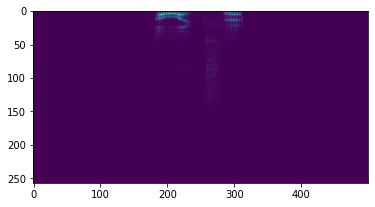

In [337]:
plt.imshow(data_mag[:,:500])

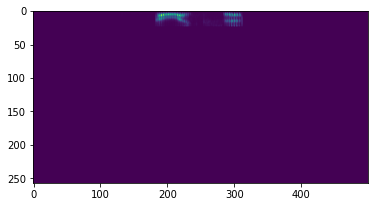

In [338]:
plt.imshow(mask[:,:500])

In [343]:
p_data = np.sqrt(np.sum(data**2))
p_noise = np.sqrt(np.sum(masked_noise**2))
snr = p_data / p_noise
print(snr)

4.693054589066456


In [344]:
print(masked_noise.max())

0.66112804


In [345]:
ipd.Audio(data, rate=fs)

In [346]:
ipd.Audio(sound + noise, rate=fs)

In [347]:
ipd.Audio(sound + masked_noise, rate=fs)

In [348]:
ipd.Audio(masked_noise, rate=fs)